In [1]:
%matplotlib inline

In [2]:
import os
import sqlite3
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np

import mercury as mr

In [3]:
# Running with Mercury to get an interactive web app needs
# (only)

# requirements.txt
# mercury
# numpy
# matplotlib

# install via 'pip install -r requirements.txt' into a clear virtual env
# tested with python 3.10

# Then you need the two SQlite databases
#   observations_lite.db   (370 MB)
#   demoddata_lite.db      (2.7 GB)
# Happy to provide these, but please contact me to get them.

In [4]:
conn = sqlite3.connect("file:observations_lite.db?mode=ro", uri=True)
conn.execute("""ATTACH DATABASE 'demoddata_lite.db' AS data;""")
conn.row_factory = sqlite3.Row

In [5]:
in_ground_station = mr.Numeric(value=834, min=0, max=4000, label='Ground station number')
ground_station = int(in_ground_station.value)

mercury.Numeric

In [6]:
in_start = mr.Text(value='2023-01-01', label='Start date', rows=1)
in_end = mr.Text(value='now', label='End date', rows=1)

if in_end.value == 'now':
    date_end = datetime.today() + timedelta(days=1)
else:
    date_end = in_end.value

date_start = in_start.value

mercury.Text

mercury.Text

In [7]:
results = conn.execute("""
SELECT id
FROM times_index
WHERE start >= strftime('%s', :start)
      AND end <= strftime('%s', :end)
      -- AND ground_station = 834
      -- AND ground_station = 2380
      -- AND ground_station = 2550
      -- AND ground_station = 2
      -- AND ground_station = 2012
      
      -- same location, yagis in opposite directions
      -- AND ground_station = 1710
      -- AND ground_station = 2029

      -- AND ground_station = 2107  -- SW-pointing yagi
      
      -- PE0SAT
      -- AND ground_station = 2173
      -- AND ground_station = 2176
      
      AND ground_station = :gs
ORDER BY start ASC;
""", dict(start=date_start, end=date_end, gs=ground_station))

obs_ids = [x['id'] for x in results]

In [8]:
# get frames for each observation
# collect rows into lists
data_lens = []
azimuths = []
elevations = []
ranges = []
nones = 0
for obs_id in obs_ids:
    results = conn.execute("""
    SELECT id, azimuth, elevation
    FROM data.obs_demoddata
    WHERE id = :id;""", [obs_id])
    
    for frame in results:
        # there may be some frames with no position information
        if frame['azimuth'] is None:
            nones += 1
            continue
        
        azimuths.append(frame['azimuth'])
        elevations.append(frame['elevation'])
        
# numpy arrays for the data
azimuths = np.array(azimuths)
elevations = np.array(elevations)


In [9]:
mr.Markdown(f"""
## Information

Source code for this app may be found at:

https://github.com/wiredlab/scheduling-bazaar/blob/master/notebooks/azel-frames-histograms.ipynb


## [Ground station # {ground_station}](https://network.satnogs.org/stations/{ground_station}) stats

- Start: {date_start}
- End: {date_end}

{len(azimuths):,} frames
""")


## Information

Source code for this app may be found at:

https://github.com/wiredlab/scheduling-bazaar/blob/master/notebooks/azel-frames-histograms.ipynb


## [Ground station # 834](https://network.satnogs.org/stations/834) stats

- Start: 2023-01-01
- End: 2023-07-17 18:01:14.988433

108,949 frames


In [10]:
# make a temporary place to save files
out_dir = mr.OutputDir()

mercury.OutputDir

## Frames per elevation angle

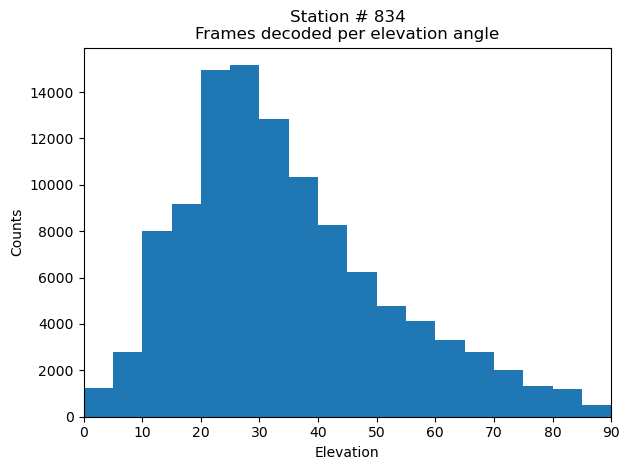

In [11]:
fig, ax = plt.subplots()
ax.hist(elevations, bins=range(0, 95, 5))
ax.set_xlabel('Elevation')
ax.set_ylabel('Counts')
ax.set_title(f'Station # {ground_station}\nFrames decoded per elevation angle')
ax.set(xlim=(0, 90))
fig.tight_layout()

plt.savefig(os.path.join(out_dir.path, f"{ground_station}_elevation.png"))

## Frames by azimuth angle

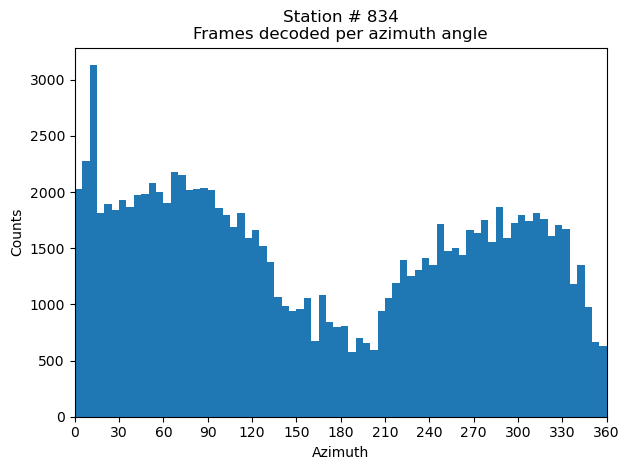

In [12]:
fig, ax = plt.subplots()
ax.hist(azimuths, bins=range(0, 365, 5))
ax.set(xlim=(0, 360), xticks=range(0, 365, 30))
ax.set_xlabel('Azimuth')
ax.set_ylabel('Counts')
ax.set_title(f'Station # {ground_station}\nFrames decoded per azimuth angle')
fig.tight_layout()

plt.savefig(os.path.join(out_dir.path, f"{ground_station}_azimuth.png"))

## Frames in 2d

In [13]:
azimuths_radians = azimuths * (np.pi / 180)
zenith_angle_degrees = (90 - elevations)
zenith_angle_radians = zenith_angle_degrees * (np.pi / 180)

def polar2z(r, theta):
    return r * np.exp(1j * theta)

def polar2xy(r, theta):
    z = polar2z(r, theta)
    return (z.real, z.imag)

def compass2xy(r, az):
    az_rad = az * (np.pi / 180)
    return polar2xy(r, -1*az_rad + np.pi/2)

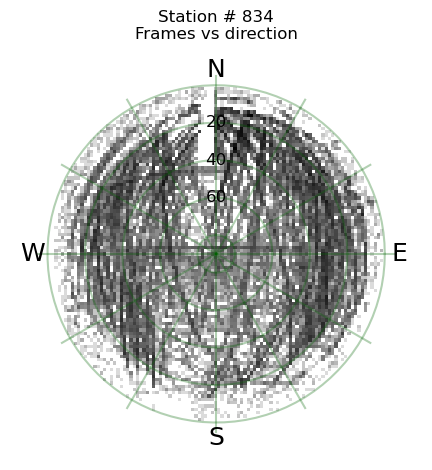

In [14]:
x, y = compass2xy(zenith_angle_degrees, azimuths)

from matplotlib import colors
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(x, y,
                 bins=101,
                 density=True,
                 norm=colors.LogNorm(),
                 cmap=plt.cm.gray_r)
ax.set_aspect('equal')
ax.set(xlim=(-110, 110), ylim=(-110, 110))

bins, xedges, yedges, _ = hist

#ax.set_facecolor('white')
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)

# axes ticks aren't useful
ax.set_xticks([])
ax.set_yticks([])

# add polar ticks
axes_color = 'darkgreen'
# elevation circles
angle = np.linspace(0, 2*np.pi, 100)
for r in np.arange(90, 0, -20):
    ax.plot(r*np.cos(angle), r*np.sin(angle), color=axes_color, alpha=0.3)

# azimuth rays
for a in range(0, 360, 30):
    a, b = compass2xy(95, a)
    ax.plot([0, a], [0, b], color=axes_color, alpha=0.3)

# cardinal directions
news = ((0, 98, 'N'),
        (0, -98, 'S'),
        (-98, 0, 'W'),
        (98, 0, 'E'))

for a, b, t in news:
    ax.text(a, b, t,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=18,
            color='black')

# elevation labels
for elev in range(20, 80, 20):
    a, b = compass2xy(90 - elev, 0)
    ax.text(a, b, f"{elev:d}",
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=12,
            color='black')

ax.set_title(f"Station # {ground_station}\nFrames vs direction")

plt.savefig(os.path.join(out_dir.path, f"{ground_station}_polar.png"))


## Low elevation azimuth histogram

In [15]:
max_elevation = mr.Numeric(value=30, min=0, max=90, label='Max elevation for AZ histogram')

mercury.Numeric

In [16]:
idx = elevations <= max_elevation.value

In [17]:
horizon_azimuths = azimuths[idx]

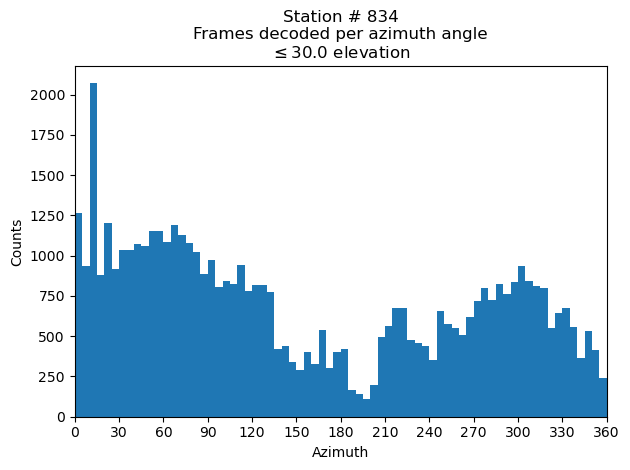

In [18]:
fig, ax = plt.subplots()
ax.hist(horizon_azimuths, bins=range(0, 365, 5))
ax.set(xlim=(0, 360), xticks=range(0, 365, 30))
ax.set_xlabel('Azimuth')
ax.set_ylabel('Counts')
ax.set_title(f'Station # {ground_station}\nFrames decoded per azimuth angle\n$\leq${max_elevation.value:.1f} elevation')
fig.tight_layout()

plt.savefig(os.path.join(out_dir.path, f"{ground_station}_horizon_azimuth.png"))

In [19]:
mr.Markdown('''
## Download images

The plots are available for you to download!

Select the "**Output Files** icon on the left side bar.
''')


## Download images

The plots are available for you to download!

Select the "**Output Files** icon on the left side bar.
